In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import cftime
import pandas as pd
from datetime import datetime
import matplotlib.colors as mcolors
from scipy.stats import linregress
from eofs.xarray import Eof
from eofs.examples import example_data_path

#My Functions
import importlib
import trend_projection_functions_new_method
importlib.reload(trend_projection_functions_new_method)
from trend_projection_functions_new_method import get_time_bounds
from trend_projection_functions_new_method import get_models_for_experiment
from trend_projection_functions_new_method import CVDP_EM_crop_NA_sector#
from trend_projection_functions_new_method import open_cropNA_unitshPA
from trend_projection_functions_new_method import calculate_spatial_ensemble_mean
from trend_projection_functions_new_method import calculate_seasonal_spatial_ensemble_mean_djf
from trend_projection_functions_new_method import calculate_linear_trend_spat_pattern
from trend_projection_functions_new_method import calculate_regression_map
from trend_projection_functions_new_method import project_onto_regression

In [2]:
def weighted_inner(EOF1, EOF2):
    """
    Compute weighted inner product between two EOFs (DataArrays lat x lon)
    """
    inner = (EOF1 * EOF2).sum(dim=('lat','lon'))
    norm1 = np.sqrt((EOF1**2).sum(dim=('lat','lon')))
    norm2 = np.sqrt((EOF2**2).sum(dim=('lat','lon')))
    cos_sim = inner / (norm1 * norm2)
    return float(inner), float(cos_sim)
    
EOF = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/concatenating/psl_mon_historical_HadGEM3-GC31-LL_DJF_EOF_pattern_concat_1850-20154.nc')
print(EOF)

EOF_NAO = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/concatenating/psl_mon_historical_HadGEM3-GC31-LL_DJF_EOF_pattern_concat_1850-20154.nc').sel(mode=0)['eofs']
EOF_EA = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/concatenating/psl_mon_historical_HadGEM3-GC31-LL_DJF_EOF_pattern_concat_1850-20154.nc').sel(mode=1)['eofs']

inner, cos_sim = weighted_inner(EOF_NAO, EOF_EA)
print(inner, cos_sim)

home = '/gws/nopw/j04/extant/users/slbennie/'
folder_path = f'{home}trend_calc_LESFMIP/linear_regression/NAO/historical/HadGEM3-GC31-LL/'
ens_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if 'HadGEM3-GC31-LL' in filename and '1850-2015' in filename]
trend_raw = open_cropNA_unitshPA(ens_files[0])#, 1850,2014)
trend_raw = trend_raw * 165

<xarray.Dataset> Size: 22kB
Dimensions:  (mode: 2, lat: 25, lon: 53)
Coordinates:
  * mode     (mode) int64 16B 0 1
  * lat      (lat) float64 200B 20.0 22.5 25.0 27.5 30.0 ... 72.5 75.0 77.5 80.0
  * lon      (lon) float64 424B -90.0 -87.5 -85.0 -82.5 ... 32.5 35.0 37.5 40.0
Data variables:
    eofs     (mode, lat, lon) float64 21kB ...
-2.498001805406602e-16 -2.498001805406601e-16


In [3]:
import xarray as xr
import numpy as np

if isinstance(trend_raw, xr.DataArray):
    trend = trend_raw
else:
    print('here')
    trend = trend_raw['slope']
    
# --- Step 1: Align grids ---
EOF_NAO_interp = EOF_NAO.interp(lat=trend['lat'], lon=trend['lon'])
EOF_EA_interp  = EOF_EA.interp(lat=trend['lat'], lon=trend['lon'])

# --- Step 2: Apply consistent mask ---
valid_mask = np.isfinite(trend)
trend_masked = trend.where(valid_mask).fillna(0)
EOF_NAO_masked = EOF_NAO_interp.where(valid_mask).fillna(0)
EOF_EA_masked  = EOF_EA_interp.where(valid_mask).fillna(0)

# --- Step 3: Apply solver weights ---
w = np.sqrt(np.cos(np.radians(trend['lat'])))
w2d, _ = xr.broadcast(w, trend)
Y  = (trend_masked * w2d).stack(spatial=('lat','lon')).values
E1 = (EOF_NAO_masked).stack(spatial=('lat','lon')).values
E2 = (EOF_EA_masked ).stack(spatial=('lat','lon')).values

# --- Optional: check orthogonality ---
inner = np.dot(E1, E2)
cos_sim = inner / (np.linalg.norm(E1) * np.linalg.norm(E2))
inner2, cos_sim2 = weighted_inner(EOF_NAO, EOF_EA)

print("Weighted inner product:", inner, inner2)
print("Weighted cosine similarity:", cos_sim, inner2)
#there has been a slight change in EOF orthogonality when masking etc. and matching grids - could do this all prior to calc EOFS.

# --- Step 4: Stack EOFs into matrix ---
E = np.stack([E1, E2], axis=1)  # N x 2

# --- Step 5: Solve weighted least squares ---
c = np.linalg.lstsq(E, Y, rcond=None)[0]  # [c_NAO, c_EA]

# --- Step 6: Reconstruct projections ---
Y_hat_NAO = c[0] * E1
Y_hat_EA  = c[1] * E2
Y_hat_total = Y_hat_NAO + Y_hat_EA
residual = Y - Y_hat_total

# --- Step 7: Variance decomposition ---
SST = np.sum(Y**2)
R2_NAO = np.dot(Y_hat_total, Y_hat_NAO) / SST
R2_EA  = np.dot(Y_hat_total, Y_hat_EA) / SST
R2_res = np.sum(residual**2) / SST

print("R² NAO       :", R2_NAO)
print("R² EA        :", R2_EA)
print("R² residual  :", R2_res)
print("Check sum    :", R2_NAO + R2_EA + R2_res)  # should be 1


here
Weighted inner product: -2.626183918084243e-16 -2.498001805406602e-16
Weighted cosine similarity: -2.626183918084242e-16 -2.498001805406602e-16
R² NAO       : 0.6018582763618642
R² EA        : 0.13585626603985346
R² residual  : 0.2622854575982821
Check sum    : 0.9999999999999998


In [4]:
EOF_NAO = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/concatenating/psl_mon_historical_HadGEM3-GC31-LL_DJF_EOF_pattern_concat_1850-20153.nc').sel(mode=0)['eofs']
EOF_EA = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/regression_patterns/concatenating/psl_mon_historical_HadGEM3-GC31-LL_DJF_EOF_pattern_concat_1850-20153.nc').sel(mode=1)['eofs']


home = '/gws/nopw/j04/extant/users/slbennie/'
folder_path = f'{home}trend_calc_LESFMIP/linear_regression/NAO/historical/HadGEM3-GC31-LL/'
ens_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if 'HadGEM3-GC31-LL' in filename and '1850-2015' in filename]
trend_raw = open_cropNA_unitshPA(ens_files[0])#, 1850,2014)
trend_raw = trend_raw * 165

if isinstance(trend_raw, xr.DataArray):
    trend = trend_raw
else:
    print('here')
    trend = trend_raw['slope']
    
# --- Solver weight ---
w = np.sqrt(np.cos(np.radians(trend['lat'])))
w2d, _ = xr.broadcast(w, trend)  # shape lat x lon

# --- Apply consistent mask: NaNs in trend are masked in EOFs ---
valid = np.isfinite(trend)
trend_masked = trend.where(valid).fillna(0)
EOF_NAO_masked = EOF_NAO.where(valid).fillna(0)
EOF_EA_masked  = EOF_EA.where(valid).fillna(0)

# --- Flatten and apply weights ---
Y  = (trend_masked * w2d).stack(spatial=('lat','lon')).values
E1 = (EOF_NAO_masked).stack(spatial=('lat','lon')).values
E2 = (EOF_EA_masked).stack(spatial=('lat','lon')).values
E  = np.stack([E1, E2], axis=1)  # N x 2

# --- Solve weighted least squares ---
c = np.linalg.lstsq(E, Y, rcond=None)[0]  # coefficients: [c_NAO, c_EA]
#basically it finds the coefficients that best approximate the trend field Y
#as a linear combination of the EOFS I have given it.


# --- Reconstruct and residual ---
#this basically reconstructs the field from the basis (EOFs -E) and their coefficients (c)
# basically: Y^=c0*E1+c1*E2
Y_hat = E @ c
residual = Y - Y_hat

# --- Variance decomposition ---
#SST = np.sum(Y**2)
#R2_NAO = c[0]**2 * np.sum(E1**2) / SST
#R2_EA  = c[1]**2 * np.sum(E2**2) / SST
#R2_res = np.sum(residual**2) / SST

Y_hat_NAO = c[0] * E1
Y_hat_EA  = c[1] * E2
residual1 = Y - Y_hat_NAO
residual  = Y - Y_hat_NAO - Y_hat_EA

Y_hat_NAO.to_netcdf('/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAtlantic_forced_trends/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_NAO_projection_1850-2015_EOF2.nc')
Y_hat_EA.to_netcdf('/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAtlantic_forced_trends/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_EA_projection_1850-2015_EOF2.nc')
residual1.to_netcdf('/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAtlantic_forced_trends/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_NAO_residual_1850-2015_EOF2.nc')
residul.to_netcdf('/gws/nopw/j04/extant/users/slbennie/projection_indicies/NAtlantic_forced_trends/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_EA_residual_1850-2015_EOF2.nc')


SST = np.sum(Y**2)
R2_NAO = np.sum(Y_hat_NAO**2) / SST
R2_EA  = np.sum(Y_hat_EA**2) / SST
R2_res = np.sum(residual**2) / SST


print("R² NAO       :", R2_NAO)
print("R² EA        :", R2_EA)
print("R² residual  :", R2_res)
print("Check sum    :", R2_NAO + R2_EA + R2_res)  # should be 1


# Full reconstructed field
Y_hat_total = Y_hat_NAO + Y_hat_EA

# Residual
residual = Y - Y_hat_total

# Total variance
SST = np.sum(Y**2)

# Fraction of variance explained
R2_total = 1 - np.sum(residual**2) / SST

# Incremental contributions (optional)
# Use projection of Y_hat_total onto each mode in the weighted inner product space
R2_NAO = np.dot(Y_hat_total, Y_hat_NAO) / SST
R2_EA  = np.dot(Y_hat_total, Y_hat_EA) / SST
R2_res = np.sum(residual**2) / SST

print("R² NAO       :", R2_NAO)
print("R² EA        :", R2_EA)
print("R² residual  :", R2_res)
print("Check sum    :", R2_NAO + R2_EA + R2_res)  # should be 1



here


AttributeError: 'numpy.ndarray' object has no attribute 'to_netcdf'

In [6]:
Y_hat_NAO.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [7]:
import xarray as xr
import numpy as np
import os

# --- Load EOFs ---
EOFs = xr.open_dataset(
    '/gws/nopw/j04/extant/users/slbennie/regression_patterns/concatenating/psl_mon_historical_HadGEM3-GC31-LL_DJF_EOF_pattern_concat_1850-20153.nc'
)['eofs']

EOF_NAO = EOFs.sel(mode=0)
EOF_EA  = EOFs.sel(mode=1)

# --- Load trend field ---
home = '/gws/nopw/j04/extant/users/slbennie/'
folder_path = f'{home}trend_calc_LESFMIP/linear_regression/NAO/historical/HadGEM3-GC31-LL/'
ens_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
             if 'HadGEM3-GC31-LL' in f and '1850-2015' in f]

trend_raw = open_cropNA_unitshPA(ens_files[0]) * 165
trend = trend_raw if isinstance(trend_raw, xr.DataArray) else trend_raw['slope']

# --- Weights ---
w = np.sqrt(np.cos(np.radians(trend['lat'])))
w2d, _ = xr.broadcast(w, trend)

# --- Apply consistent mask ---
valid = np.isfinite(trend)
trend_masked   = trend.where(valid).fillna(0) * w2d
EOF_NAO_masked = EOF_NAO.where(valid).fillna(0)
EOF_EA_masked  = EOF_EA.where(valid).fillna(0)

# --- Stack for regression ---
Y  = trend_masked.stack(spatial=("lat", "lon"))
E1 = EOF_NAO_masked.stack(spatial=("lat", "lon"))
E2 = EOF_EA_masked.stack(spatial=("lat", "lon"))

E  = xr.concat([E1, E2], dim="mode")  # shape: mode x spatial

# --- Solve least squares in xarray ---
# normal equations: (E E^T)c = E Y
# --- Solve least squares (normal equations) ---

# --- Solve least squares (normal equations) ---

# Gram matrix (mode x mode)
# --- Arrange regression matrix ---
# stack spatial dimension, so E has shape (spatial, mode)
E = xr.concat([E1, E2], dim="mode").transpose("spatial", "mode")
Y = trend_masked.stack(spatial=("lat", "lon"))

# --- Solve least squares directly ---
E_vals = E.values        # (n_spatial, n_modes)
Y_vals = Y.values        # (n_spatial,)

c_vals, _, _, _ = np.linalg.lstsq(E_vals, Y_vals, rcond=None)

# Wrap back in xarray
c = xr.DataArray(c_vals, dims=["mode"], coords={"mode": E.mode})




# --- Reconstruct ---
Y_hat_NAO = c.sel(mode=0) * E1
Y_hat_EA  = c.sel(mode=1) * E2
Y_hat     = Y_hat_NAO + Y_hat_EA
residual  = Y - Y_hat
residual1 = Y - Y_hat_NAO

# --- Unstack back to lat/lon fields ---
Y_hat_NAO = Y_hat_NAO.unstack("spatial")
Y_hat_EA  = Y_hat_EA.unstack("spatial")
residual  = residual.unstack("spatial")
residual1  = residual1.unstack("spatial")

Y_hat_NAO.name = "projection_NAO_djf"
Y_hat_EA.name  = "projection_EA_djf"
residual.name  = "residual_EA_djf"
residual1.name = "residual_NAO_djf"


# --- Save to NetCDF ---
outdir = f"{home}projection_indicies/NAtlantic_forced_trends/historical/HadGEM3-GC31-LL/"
Y_hat_NAO.to_netcdf(f"{outdir}psl_mon_historical_HadGEM3-GC31-LL_DJF_NAO_projection_1850-2015_EOF2.nc")
Y_hat_EA.to_netcdf(f"{outdir}psl_mon_historical_HadGEM3-GC31-LL_DJF_EA_projection_1850-2015_EOF2.nc")
residual.to_netcdf(f"{outdir}psl_mon_historical_HadGEM3-GC31-LL_DJF_EA_residual_1850-2015_EOF2.nc")
residual1.to_netcdf(f"{outdir}psl_mon_historical_HadGEM3-GC31-LL_DJF_NAO_residual_1850-2015_EOF2.nc")

# --- Variance decomposition ---
SST = (Y**2).sum().item()
R2_NAO = ((Y_hat_NAO.stack(spatial=("lat", "lon"))**2).sum() / SST).item()
R2_EA  = ((Y_hat_EA.stack(spatial=("lat", "lon"))**2).sum() / SST).item()
R2_res = ((residual.stack(spatial=("lat", "lon"))**2).sum() / SST).item()

print("R² NAO       :", R2_NAO)
print("R² EA        :", R2_EA)
print("R² residual  :", R2_res)
print("Check sum    :", R2_NAO + R2_EA + R2_res)


R² NAO       : 0.6018582763618644
R² EA        : 0.13585626603985326
R² residual  : 0.26228545759828203
Check sum    : 0.9999999999999997


In [8]:
Y_hat_NAO = xr.open_dataset(f"{outdir}psl_mon_historical_HadGEM3-GC31-LL_DJF_NAO_projection_1850-2015_EOF2.nc")['projection_NAO_djf']
Y_hat_EA = xr.open_dataset(f"{outdir}psl_mon_historical_HadGEM3-GC31-LL_DJF_EA_projection_1850-2015_EOF2.nc")['projection_EA_djf']
residual = xr.open_dataset(f"{outdir}psl_mon_historical_HadGEM3-GC31-LL_DJF_EA_residual_1850-2015_EOF2.nc")['residual_EA_djf']
residual1 = xr.open_dataset(f"{outdir}psl_mon_historical_HadGEM3-GC31-LL_DJF_NAO_residual_1850-2015_EOF2.nc")['residual_NAO_djf']

# --- Variance decomposition ---
SST = (Y**2).sum().item()
R2_NAO = ((Y_hat_NAO.stack(spatial=("lat", "lon"))**2).sum() / SST).item()
R2_EA  = ((Y_hat_EA.stack(spatial=("lat", "lon"))**2).sum() / SST).item()
R2_res = ((residual.stack(spatial=("lat", "lon"))**2).sum() / SST).item()

print("R² NAO       :", R2_NAO)
print("R² EA        :", R2_EA)
print("R² residual  :", R2_res)
print("Check sum    :", R2_NAO + R2_EA + R2_res)



R² NAO       : 0.6018582763618644
R² EA        : 0.13585626603985326
R² residual  : 0.26228545759828203
Check sum    : 0.9999999999999997


In [9]:
ds = xr.open_dataset(f"{outdir}psl_mon_historical_HadGEM3-GC31-LL_DJF_NAO_projection_1850-2015_EOF2.nc")

In [10]:
ds

<xarray.Dataset> Size: 11kB
Dimensions:             (lat: 25, lon: 53)
Coordinates:
  * lat                 (lat) float64 200B 20.0 22.5 25.0 ... 75.0 77.5 80.0
  * lon                 (lon) float64 424B -90.0 -87.5 -85.0 ... 35.0 37.5 40.0
    mode                int64 8B ...
Data variables:
    projection_NAO_djf  (lat, lon) float64 11kB ...

In [11]:
import xarray as xr
import numpy as np
import os
# --- Load EOFs ---
EOFs = xr.open_dataset(
    '/gws/nopw/j04/extant/users/slbennie/regression_patterns/concatenating/psl_mon_historical_HadGEM3-GC31-LL_DJF_EOF_pattern_concat_1850-20153.nc'
)['eofs']

# --- Load trend field ---
home = '/gws/nopw/j04/extant/users/slbennie/'
folder_path = f'{home}trend_calc_LESFMIP/linear_regression/NAO/historical/HadGEM3-GC31-LL/'
ens_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
             if 'HadGEM3-GC31-LL' in f and '1850-2015' in f]

trend_raw = open_cropNA_unitshPA(ens_files[0]) * 165
trend = trend_raw if isinstance(trend_raw, xr.DataArray) else trend_raw['slope']

# --- Weights ---
w = np.sqrt(np.cos(np.radians(trend['lat'])))
w2d, _ = xr.broadcast(w, trend)

# --- Apply consistent mask ---
valid = np.isfinite(trend)
trend_masked = trend.where(valid).fillna(0) * w2d
EOFs_masked  = EOFs.where(valid).fillna(0)

# --- Stack spatial dimension ---
Y = trend_masked.stack(spatial=("lat", "lon"))
E = EOFs_masked.stack(spatial=("lat", "lon")).transpose("spatial", "mode")

# --- Solve least squares ---
E_vals = E.values        # (n_spatial, n_modes)
Y_vals = Y.values        # (n_spatial,)

c_vals, _, _, _ = np.linalg.lstsq(E_vals, Y_vals, rcond=None)

# Wrap coefficients back in xarray
c = xr.DataArray(c_vals, dims=["mode"], coords={"mode": E.mode})

# --- Reconstruct projections ---
projections = []
for mode in E.mode.values:
    proj = c.sel(mode=mode) * EOFs_masked.sel(mode=mode)
    proj.name = f"projection_mode{int(mode)}"
    projections.append(proj)

# Total reconstruction
Y_hat = sum(projections)
residual = Y.unstack("spatial") - Y_hat

# --- Save outputs ---
outdir = f"{home}projection_indicies/NAtlantic_forced_trends/historical/HadGEM3-GC31-LL/"
for proj in projections:
    proj.to_netcdf(f"{outdir}psl_mon_historical_HadGEM3-GC31-LL_DJF_{proj.name}_1850-2015.nc")

residual.to_netcdf(f"{outdir}psl_mon_historical_HadGEM3-GC31-LL_DJF_residual_1850-2015.nc")

# --- Variance decomposition ---
SST = (Y**2).sum().item()
R2_modes = {}
for proj in projections:
    r2 = ((proj.stack(spatial=("lat", "lon"))**2).sum() / SST).item()
    R2_modes[proj.name] = r2

R2_res = ((residual.stack(spatial=("lat", "lon"))**2).sum() / SST).item()

print("Variance explained by each mode:")
for name, r2 in R2_modes.items():
    print(f"  {name}: {r2:.3f}")
print("Residual:", R2_res)
print("Check sum:", sum(R2_modes.values()) + R2_res)


Variance explained by each mode:
  projection_mode0: 0.602
  projection_mode1: 0.136
Residual: 0.26228545759828203
Check sum: 0.9999999999999997


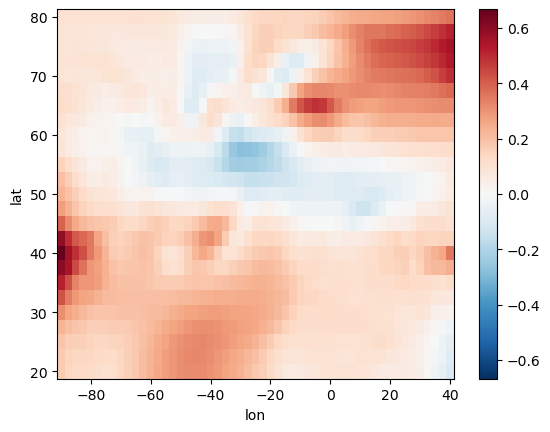

In [17]:
residual.plot()